In [96]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [97]:
# Import the Mall_Customers.csv dataset

dataset = pd.read_csv("src/Mall_Customers.csv")
print("Dataset loaded successfully")

Dataset loaded successfully


In [98]:
# Basic statistics and dataset overview
print("Dataset Overview:")
print(f"Number of rows: {dataset.shape[0]}")
print(f"Number of columns: {dataset.shape[1]}")
print()

# Display first few rows of the dataset
print("Preview of the dataset:")
display(dataset.head())
print()

# Basic statistics
print("Basic statistics for numerical and categorical columns:")
data_desc = dataset.describe(include="all")
display(data_desc)
print()

# Percentage of missing values for each column
print("Percentage of missing values in each column:")
missing_values = 100 * dataset.isnull().sum() / dataset.shape[0]
display(missing_values)

Dataset Overview:
Number of rows: 200
Number of columns: 5

Preview of the dataset:


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40



Basic statistics for numerical and categorical columns:


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000



Percentage of missing values in each column:


CustomerID                0.0
Genre                     0.0
Age                       0.0
Annual Income (k$)        0.0
Spending Score (1-100)    0.0
dtype: float64

Remove the "CustomerID" variable from your dataset.

In [99]:
dataset_new = dataset.drop(columns="CustomerID")

# Display first few rows of the dataset
print("Preview of the dataset:")
display(dataset_new.head())
print()

Preview of the dataset:


,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


Make all the preprocessings

In [100]:
# Détection automatique des colonnes numériques et catégorielles
numeric_features = [col for col in dataset_new.columns if dataset_new[col].dtype in ['float64', 'int64']]
categorical_features = [col for col in dataset_new.columns if dataset_new[col].dtype == 'object']

print("Found numeric features:", numeric_features)
print("Found categorical features:", categorical_features)

Found numeric features: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
Found categorical features: ['Genre']


In [101]:
numeric_transformer = Pipeline(
    steps=[
    ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop="first"))
    ]
)

In [102]:
# Création de l'objet de prétraitement qui applique les transformations aux colonnes numériques et catégorielles
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),     # Applique le pipeline numérique aux caractéristiques numériques
        ('cat', categorical_transformer, categorical_features)  # Applique le pipeline catégoriel aux caractéristiques catégorielles
    ]
)

print("Preprocessor object created with transformations for numeric and categorical features.")

Preprocessor object created with transformations for numeric and categorical features.


In [103]:
# Prétraitement sur l'ensemble des données
print("Performing preprocessing on train set...")
print(dataset_new.head())
dataset_cleaned = preprocessor.fit_transform(dataset_new)
print("...Done.")

# Convertit en DataFrame pour garder les noms de colonnes après transformation
dataset_cleaned = pd.DataFrame(dataset_cleaned, columns=preprocessor.get_feature_names_out())
dataset_cleaned.head()

Performing preprocessing on train set...
    Genre  Age  Annual Income (k$)  Spending Score (1-100)
0    Male   19                  15                      39
1    Male   21                  15                      81
2  Female   20                  16                       6
3  Female   23                  16                      77
4  Female   31                  17                      40
...Done.


,num__Age,num__Annual Income (k$),num__Spending Score (1-100),cat__Genre_Male
0,-1.424569,-1.738999,-0.434801,1.0
1,-1.281035,-1.738999,1.195704,1.0
2,-1.352802,-1.700830,-1.715913,0.0
3,-1.137502,-1.700830,1.040418,0.0
4,-0.563369,-1.662660,-0.395980,0.0


We are going to build our clusters, but to do so, we need to know the optimum number of clusters we need. First use the Elbow method to see if we can see how many we need to take as a value for k.

WCSS pour K=1 --> 649.2799999999999
WCSS pour K=2 --> 438.5224115567775
WCSS pour K=3 --> 346.03755477146717
WCSS pour K=4 --> 254.36171423484495
WCSS pour K=5 --> 227.01672798042068
WCSS pour K=6 --> 194.00424193610988
WCSS pour K=7 --> 183.02849608193486
WCSS pour K=8 --> 151.03482636968909
WCSS pour K=9 --> 145.79221950395086
WCSS pour K=10 --> 141.2394489772611


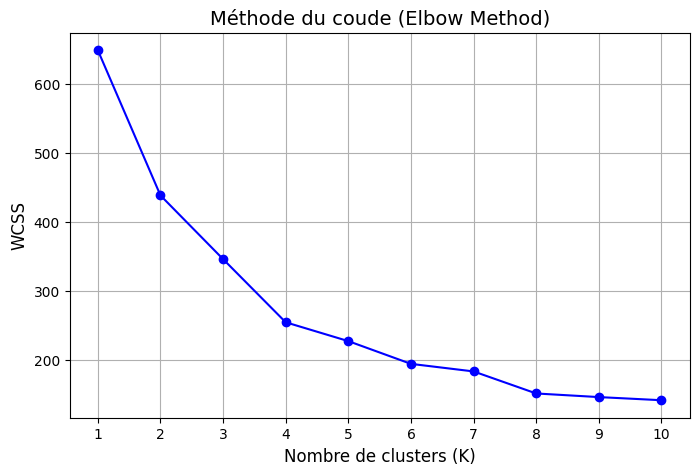

In [104]:
# Initialisation des listes pour stocker les résultats
wcss = []
k_values = list(range(1, 11))  # Liste des valeurs de K de 1 à 10

# Boucle pour calculer WCSS pour chaque valeur de K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(dataset_cleaned)
    wcss.append(kmeans.inertia_)
    print(f"WCSS pour K={k} --> {wcss[-1]}")

# Visualisation de WCSS en fonction de K
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.title("Méthode du coude (Elbow Method)", fontsize=14)
plt.xlabel("Nombre de clusters (K)", fontsize=12)
plt.ylabel("WCSS", fontsize=12)
plt.xticks(k_values)
plt.grid(True)
plt.show()

Then use the Silhouette method to see if we can refine our hypothesis for k.

Score de silhouette pour K=2 --> 0.3032
Score de silhouette pour K=3 --> 0.3121
Score de silhouette pour K=4 --> 0.3504
Score de silhouette pour K=5 --> 0.3102
Score de silhouette pour K=6 --> 0.3149
Score de silhouette pour K=7 --> 0.2881
Score de silhouette pour K=8 --> 0.3320
Score de silhouette pour K=9 --> 0.3020
Score de silhouette pour K=10 --> 0.3002


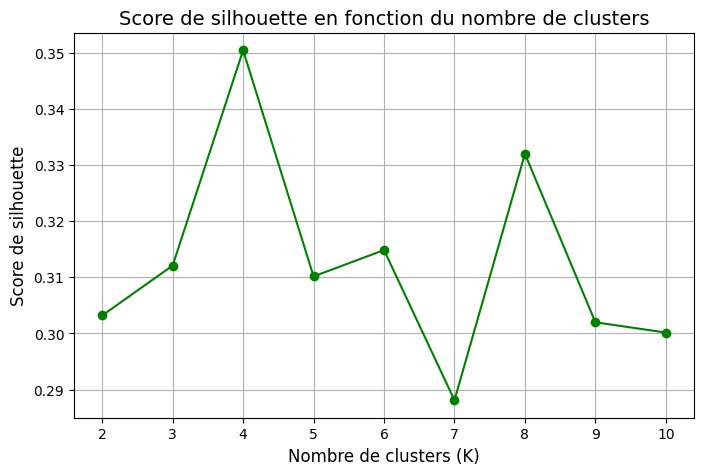

In [105]:
# Initialisation des listes pour stocker les résultats
silhouette_scores = []
k_values = list(range(2, 11))  # Les valeurs de K commencent à 2

# Calcul des scores de silhouette pour chaque valeur de K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(dataset_cleaned)
    score = silhouette_score(dataset_cleaned, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Score de silhouette pour K={k} --> {score:.4f}")

# Visualisation des scores de silhouette
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='g')
plt.title("Score de silhouette en fonction du nombre de clusters", fontsize=14)
plt.xlabel("Nombre de clusters (K)", fontsize=12)
plt.ylabel("Score de silhouette", fontsize=12)
plt.xticks(k_values)
plt.grid(True)
plt.show()

Next, we will take K=6 clusters. Apply the KMeans to your dataset.

In [106]:
# Application de KMeans
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(dataset_cleaned)

KMeans(n_clusters=6, random_state=0)

In [107]:
# Ajouter la colonne 'Cluster_KMeans' avec les prédictions du modèle KMeans
dataset_cleaned['Cluster_KMeans'] = kmeans.predict(dataset_cleaned)

# Afficher les premières lignes du DataFrame mis à jour
dataset_cleaned.head()

,num__Age,num__Annual Income (k$),num__Spending Score (1-100),cat__Genre_Male,Cluster_KMeans
0,-1.424569,-1.738999,-0.434801,1.0,5
1,-1.281035,-1.738999,1.195704,1.0,5
2,-1.352802,-1.700830,-1.715913,0.0,1
3,-1.137502,-1.700830,1.040418,0.0,5
4,-0.563369,-1.662660,-0.395980,0.0,5


Let's create a graph that will allow us to visualize each of the clusters. We will first take the Spending Score as the ordinate and the Annual Income as the abscissa.

In [111]:
# Création de la visualisation bi-dimensionnelle
fig = px.scatter(
    dataset_cleaned, 
    x='num__Annual Income (k$)', 
    y='num__Spending Score (1-100)', 
    color='Cluster_KMeans', 
    title='Visualisation des clusters KMeans',
)

# Affichage de la figure
fig.show()

We have a nice visualization with a nice cluster separation. Look this time at the variable Age in relation to the Spending Score. What do you notice?

In [113]:
# Création de la visualisation bi-dimensionnelle
fig = px.scatter(
    dataset_cleaned, 
    x='num__Age', 
    y='num__Spending Score (1-100)', 
    color='Cluster_KMeans', 
    title='Visualisation des clusters KMeans',
)

# Affichage de la figure
fig.show()

----> This time clusters are definitely less visible.

Finally, make a 3d scatter plot of your clusters by using all the quantitative features

In [117]:
# Création d'une visualisation 3D
fig = px.scatter_3d(
    dataset_cleaned,
    x='num__Annual Income (k$)',
    y='num__Spending Score (1-100)',
    z='num__Age',
    color='Cluster_KMeans',
    title="Visualisation des clusters dans l'espace 3D",
)

# Affichage de la figure
fig.show()